In [34]:
import os
from pathlib import Path
import pyrootutils

notebook_path = Path(os.path.abspath(""))
pyrootutils.setup_root(notebook_path, indicator=".project-root", pythonpath=True)

DIRNAME = r"/cluster/home/vjimenez/adv_pa_new/results/dg/datashift"

In [35]:
from src.plot.dg import *
from src.plot.dg._retrieve import *
from src.plot.dg._plot import *

In [36]:
LIST_PASPECIFIC_METRICS = ["logPA", "beta", "acc_pa", "AFR_true", "AFR_pred", "CD", "MMD", "FID", "CS", "KL", "W", "oracle"]

def _get_metric_value(
        data,
        list_metric_indexes,
        metric_name,
        run_ind,
        env = 1
    ):
    pos_to_select = list_metric_indexes[env-1][run_ind]
    try:
        if metric_name in LIST_PASPECIFIC_METRICS:
            key_name = f"PA(0,{env})/{metric_name}"
            if metric_name == "oracle":
                key_name = f"oracle/acc_{env-1}"
                
            out = data[key_name][run_ind][pos_to_select].item()
        else:
            out = data[f"{metric_name}"][run_ind][pos_to_select].item()
    except:
        import ipdb; ipdb.set_trace()
    return out

# Apply selection functions to the metric:
def _fun_selection_metric(metric_array, selection_criterion) -> int:
    if selection_criterion == "min":
        return np.argmin(metric_array).item()
    elif selection_criterion == "max":
        return np.argmax(metric_array).item()
    elif selection_criterion == "first":
        return 0
    else:
        return -1

def _generate_indexes(
        data,
        selection_metric,
        selection_criterion,
        selection_environment = None
    ):
    run_names = list(data.keys())
    num_runs = len(data[run_names[0]])

    # Environments to select from:
    envs_to_select = [selection_environment]*5
    if selection_environment == None:
        envs_to_select = [i for i in range(1, 6)]

    # Select the metric indexes:
    datakey = lambda env: selection_metric
    if selection_metric in LIST_PASPECIFIC_METRICS:
        datakey = lambda env: f"PA(0,{env})/{selection_metric}"
        if selection_metric == "oracle":
            datakey = lambda env: f"oracle/acc_{env-1}"

    try:
        list_metric_indexes = [
            [
                _fun_selection_metric(
                    data[datakey(env)][i],
                    selection_criterion
                )
                for i in range(num_runs)
            ]
            for env in envs_to_select
        ]
    except:
        import ipdb; ipdb.set_trace()
    return list_metric_indexes

In [37]:
def plot_dg_nsf(
        data: dict,
        metric: str,
        selection_metric: str,
        selection_criterion: str,
        savedir: str,
        selection_environment: Optional[int] = None,
        selection_index: Optional[int] = None,
        yscale: Optional[bool] = "symlog",
        legend: Optional[bool] = True,
        save: Optional[bool] = False,
    ) -> None:
    """
        Args:
            data (dict): Dictionary with all the data for the desired runs.
            metric (str): Name of the metric to plot.
            selection_metric (str): Name of the metric that guides the selection of the `metric` values to plot.
            selection_criterion (str): Criterion of the `selection_metric`. Accepts "min", "max", "first" and "last".
            selection_environment (Optional[int]): Environment to implement the selection criterion. If None, it will be implemented
                for each environment separately.
    """
    assert selection_criterion in ["min", "max", "first", "last"], "Please specify an accepted selection criterion."

    # Number of runs:
    run_names = list(data.keys())
    num_runs = len(data[run_names[0]])            

    # Get the font
    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))

    # Get indexes from the metric of interest
    if selection_index == None:
        indexes_list = _generate_indexes(data, selection_metric, selection_criterion, selection_environment)
    else:
        list_envs = [i for i in range(1, 6)] if selection_environment==None else [selection_environment]
        indexes_list = [
            selection_index
            for run_ind in range(num_runs)
            for env in list_envs
        ]

    _get_value = functools.partial(_get_metric_value, data=data, list_metric_indexes=indexes_list)
    print(f"\nSelected indexes for each env: {indexes_list}\n")

    # Subset of the dictionary:
    dict_to_plot = {
        "num_factors": np.concatenate([
            np.arange(1, 6, dtype=int) for _ in range(num_runs)
        ]),
    }

    # List of environments:
    list_envs = [1]*5
    if metric in LIST_PASPECIFIC_METRICS:
        list_envs = [i for i in range(1, 6)]
    
    dict_to_plot.update(
        {   
            "model": [
                data["model"][run_ind]
                for run_ind in range(num_runs)
                for env in list_envs
            ],

            metric: np.concatenate([
                np.asarray([
                    _get_value(metric_name=metric, run_ind=run_ind, env=env)
                    for env in list_envs
                ])
            for run_ind in range(num_runs)
            ])
        }
    )
    level_set = pd.DataFrame(dict_to_plot)
    
    # Create a line plot
    _, ax = plt.subplots(figsize=(2 * 3.861, 2 * 2.7291))
    sns.set(font_scale=1.9)
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = fontname
    sns.set_style("ticks")

    print(level_set)
    
    sns.lineplot(
        data=level_set,
        ax=ax,
        x="num_factors",
        y=metric,
        hue="model",
        style="model",
        palette=COLORS_DICT,
        dashes=False,
        marker="o",
        linewidth=3,
        legend=legend
    )

    ax.minorticks_on()
    ax.set_xticks([i for i in range(1,6)])

    ax.tick_params(axis="both", which="both", direction="in")
    xticks_font = fm.FontProperties(family=fontname)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(xticks_font)

    ax.grid(linestyle="--")

    # ax.set_ylim(0.945, 1.0)
        
    # posdiff = -(10**np.log10(abs(max(level_set[metric]))))/2
    # ax.set_ylim(min(level_set[metric])*2, posdiff)
    ax.set_xlabel("# Shift Factors", fontname=fontname)
    # r"$10^{-4} \times $ PA"
    ax.set_ylabel("Accuracy", fontname=fontname)
    ax.set_yscale(yscale) 
    
    # Legend
    if legend == True:
        handles, labels = ax.get_legend_handles_labels()
        labels = [LABELS_DICT[label] for label in labels]
        legend_properties = {
            "family": fontname,
            'size': 18
        }  
        ax.legend(
            handles,
            labels,
            # loc="best",
            loc="lower left",
            # fontsize=12,
            handlelength=0.5,
            prop=legend_properties
        )

    title = "ERM, Epoch (2)"
    ax.set_title(title, fontname=fontname)
    plt.tight_layout()
    if save:
        plt.savefig(savedir, dpi=300)
        plt.clf()
        plt.close()
    else:
        plt.show()

In [32]:
data_dict = get_multiple_dict(dataset_names=["paper"], run_names=["erm_gpu"], datashift = True)

Run: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


In [33]:
max_val = np.argmax(data_dict["val/acc"])
data_dict["PA(0,1)/beta"][0][max_val].item()

3.022533416748047

In [31]:
plot_dg_nsf(
        data = data_dict,
        metric = "AFR_pred",
        selection_metric = "logPA",
        selection_criterion = "max",
        # selection_environment = 1,
        selection_index = None,
        yscale = "linear",
        legend = True,
        savedir=r"delete2.png",
        save = True
)


Selected indexes for each env: [[31], [21], [21], [21], [16]]

   num_factors model  AFR_pred
0            1   ERM    0.9989
1            2   ERM    0.9756
2            3   ERM    0.9794
3            4   ERM    0.9759
4            5   ERM    0.9105


In [38]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


def plot_dg_selection(
        data: dict,
        savedir: str,
        legend: Optional[bool] = True,
        save: Optional[bool] = False,
    ) -> None:
    """
        Args:
            data (dict): Dictionary with all the data for the desired runs.
            metric (str): Name of the metric to plot.
            selection_metric (str): Name of the metric that guides the selection of the `metric` values to plot.
            selection_criterion (str): Criterion of the `selection_metric`. Accepts "min", "max", "first" and "last".
            selection_environment (Optional[int]): Environment to implement the selection criterion. If None, it will be implemented
                for each environment separately.
    """
    # Number of runs:
    run_names = list(data.keys())
    num_runs = len(data[run_names[0]])            

    # Get the font
    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))
    
    df_list = []
    selection_index = None
    iterator = zip(
                ["oracle", "oracle", "oracle"], # metric to plot
                ["oracle", "logPA", "val/acc"], # selection metric
                ["max", "max", "max"], # criterion
                [None, 1, 1] # selection environment
    )
    for metric, selection_metric, selection_criterion, selection_environment in iterator:
        # Get indexes from the metric of interest
        if selection_index == None:
            indexes_list = _generate_indexes(data, selection_metric, selection_criterion, selection_environment)
        else:
            list_envs = [i for i in range(1, 6)] if selection_environment==None else [selection_environment]
            indexes_list = [
                selection_index
                for run_ind in range(num_runs)
                for env in list_envs
            ]

        _get_value = functools.partial(_get_metric_value, data=data, list_metric_indexes=indexes_list)
        print(f"\nSelected indexes for each env: {indexes_list}\n")

        # Subset of the dictionary:
        dict_to_plot = {
            "num_factors": np.concatenate([
                np.arange(1, 6, dtype=int) for _ in range(num_runs)
            ]),
        }

        list_envs = [i for i in range(1, 6)]
        dict_to_plot.update(
            {   
                "model": [
                    data["model"][run_ind]
                    for run_ind in range(num_runs)
                    for env in list_envs
                ],

                metric: np.concatenate([
                    np.asarray([
                        _get_value(metric_name=metric, run_ind=run_ind, env=env)
                        for env in list_envs
                    ])
                for run_ind in range(num_runs)
                ])
            }
        )
        df_list.append(pd.DataFrame(dict_to_plot))
        

    # Create a line plot
    _, ax = plt.subplots(figsize=(2.5 * 3.861, 2 * 2.7291))
    sns.set(font_scale=1.9)
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = fontname
    sns.set_style("ticks")

    # Plot the top accuracy as a line:
    delta = 0.26
    delta_model = [-delta, 0.0, delta]
    for imodel, model in enumerate(df_list[0]["model"].unique()):
        level_set_0, level_set_1, level_set_2 = [
                df_list[i].loc[
                    (df_list[i]["model"] == model)
                ]
                for i in range(3)
        ]
        d = delta_model[imodel]
        for i in range(1, 6):
            width = 0.25
            x_left, x_right = d + i - width/2.0, d + i + width/2.0
            
            max_acc = max(level_set_1["oracle"].iloc[i-1], level_set_2["oracle"].iloc[i-1])
            errorbar = ax.bar(
                x = (x_left + x_right)/2.0,
                align = "center",
                height = max_acc,
                facecolor='none',
                edgecolor='none',
                color='black',
                yerr=np.asarray([
                    0.0, level_set_0["oracle"].iloc[i-1] - max_acc
                ])[:, np.newaxis],
                capsize=5
            )
            for cap in errorbar.errorbar[1]:
                cap.set_markeredgewidth(0)  # hide the bottom caps
                break
            
            ax.bar(
                x = x_left,
                align = "edge",
                width = width,
                height = level_set_2["oracle"].iloc[i-1], # val_acc
                color=COLORS_DICT[model],
                edgecolor=COLORS_DICT[model],
            )
            
            hatch = "//"
            if level_set_1["oracle"].iloc[i-1] > level_set_2["oracle"].iloc[i-1]:
                ax.bar(
                    x = x_left,
                    align = "edge",
                    width = width,
                    height = level_set_1["oracle"].iloc[i-1] - level_set_2["oracle"].iloc[i-1],
                    bottom = level_set_2["oracle"].iloc[i-1],
                    color=COLORS_DICT[model],
                    edgecolor=COLORS_DICT[model],
                    alpha=0.5,
                )
                ax.bar(
                    x = x_left,
                    align = "edge",
                    width = width,
                    height = level_set_1["oracle"].iloc[i-1] - level_set_2["oracle"].iloc[i-1],
                    bottom = level_set_2["oracle"].iloc[i-1],
                    facecolor='none',
                    edgecolor='lime',
                    linewidth=1.2
                )
            else:
                ax.bar(
                    x = x_left,
                    align = "edge",
                    width = width,
                    height = level_set_1["oracle"].iloc[i-1] - level_set_2["oracle"].iloc[i-1],
                    bottom = level_set_2["oracle"].iloc[i-1],
                    hatch="//",
                    facecolor='none',
                    edgecolor='tab:red',
                    linewidth=1.2
                )


    if legend == True:
        legend_bar = Patch(facecolor = "tab:blue")
        legend_bar_lower = Patch(facecolor = "tab:blue", hatch="//", linewidth=1.2, edgecolor='tab:red')
        legend_bar_higher = Patch(facecolor = "tab:blue", alpha=0.5, linewidth=1.2, edgecolor="lime")
        error_bar = mlines.Line2D([], [], color='black')

        ax.legend(
            handles=[legend_bar, (legend_bar_lower, legend_bar_higher), error_bar],
            labels=["Acc. selection", "PA selection", "Maximum"],
            loc = "upper right",
            handlelength=1.0,
            handler_map={
                mlines.Line2D: ErrorBarHandler(capsize=8),
                tuple: SideBySideHandler(),
            },
            prop = {
                "family": fontname,
                'size': 18
            }
        )
            

        
    ax.set_xticks([i for i in range(1,6)])

    ax.tick_params(axis="both", which="both", direction="in")
    xticks_font = fm.FontProperties(family=fontname)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(xticks_font)

    # ax.grid(linestyle="--")

    ax.set_ylim(0.945, 1.01)
    ax.set_xlim(0.5, 5.5)
        
    # posdiff = -(10**np.log10(abs(max(level_set[metric]))))/2
    # ax.set_ylim(min(level_set[metric])*2, posdiff)
    ax.set_xlabel("# Shift Factors", fontname=fontname)
    # r"$10^{-4} \times $ PA"
    ax.set_ylabel("Accuracy", fontname=fontname)
    ax.set_yscale("linear") 

    title = "Model selection capabilities"
    ax.set_title(title, fontname=fontname)
    plt.tight_layout()
    if save:
        plt.savefig(savedir)
        plt.clf()
        plt.close()
    else:
        plt.show()

In [28]:
data_dict = get_multiple_dict(dataset_names=["paper"], run_names=["erm", "irm", "lisa_08"], datashift = True)

Run:  67%|██████▋   | 2/3 [00:00<00:00,  5.50it/s]wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 

Failed to retrieve run-sx8on9px-history:v0: 'utf-8' codec can't decode byte 0x90 in position 101: invalid start byte



Selected indexes for each env: [[10, 3, 16], [10, 3, 86], [21, 12, 54], [21, 12, 11], [21, 12, 11]]


Selected indexes for each env: [[31, 11, 52], [31, 11, 52], [31, 11, 52], [31, 11, 52], [31, 11, 52]]


Selected indexes for each env: [[25, 80, 88], [25, 80, 88], [25, 80, 88], [25, 80, 88], [25, 80, 88]]



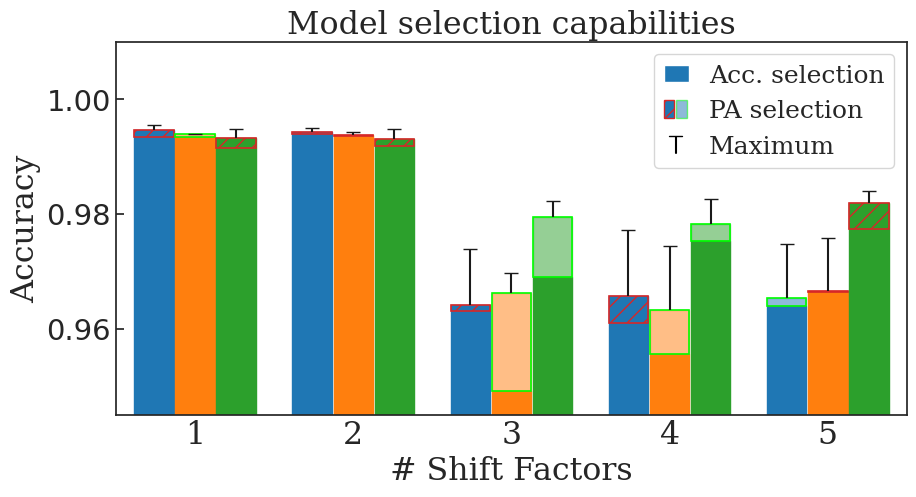

In [10]:
plot_dg_selection(
    data = data_dict,
    savedir = r"/cluster/home/vjimenez/adv_pa_new/results/dg/datashift/paper/model_selection.png",
    legend = True,
    save= False
)

In [40]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, NullLocator
import matplotlib.colors as mcolors
import matplotlib.patches as mpaches

def plot_dg_epochwise(
        data_dict: dict,
        metric_list: list[str],
        hue_attribute: str,
        hue_dict: dict,
        savedir: str,
        title: str,
        ylabel: str,
        save: bool = False,
        yscale: bool = "symlog",
        legend: bool = True,
    ) -> None:
    """
    Plot of the different metrics for adversarial ratio.
    """
    df_list = []
    num_epochs = len(data_dict["val/acc"][0])
    for imodel, model in enumerate(data_dict["model"]):
        model_dict = {
            "model": np.full(num_epochs, model),
            "epochs": np.arange(1, 101)
        }
        model_dict.update({
            metric: data_dict[metric][imodel]
            for metric in metric_list
        })
        df_list.append(pd.DataFrame(model_dict))
    df = pd.concat(df_list)
    
    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))

    # Create a line plot for PGD attack type with Seaborn
    _, ax = plt.subplots(figsize=(2 * 3.861, 2 * 2.7291))
    # _, ax = plt.subplots(figsize=(2 * 4.361, 2 * 2.7291))
    sns.set(font_scale=1.9)
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = fontname
    sns.set_style("ticks")

    # Create the discrete colormap
    n_bins = 5  # Number of discrete colors
    colors = plt.cm.Blues(np.linspace(0.3, 1, n_bins))
    cmap = mcolors.ListedColormap(colors)
    for imetric, metric in enumerate(metric_list):
        # sns.lineplot(
        #     data=df,
        #     ax=ax,
        #     x="epochs",
        #     y=metric,
        #     hue=hue_attribute,
        #     style=hue_attribute,
        #     palette=hue_dict,
        #     dashes=False,
        #     linewidth=3,
        #     legend=legend
        # )


        color = cmap((4-imetric) / (n_bins - 1))
        sns.lineplot(
            data=df,
            ax=ax,
            x="epochs",
            y=metric,
            color=color,  # Use color_with_alpha instead of base_color
            dashes=False,
            linewidth=3,
            legend=legend
        )

    bounds = np.linspace(0, 5, n_bins + 1)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Create the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Test Environments', fontname=fontname)
    cbar.set_ticks(np.arange(0.5, 5.5, 1.0))
    cbar.set_ticklabels(np.arange(6, 1, -1)-1)
    cbar.ax.tick_params(size=0)



    ax.set_xticks([1] + [i for i in range(10, 101, 10)])
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    # ax.minorticks_on()
    ax.xaxis.set_minor_locator(NullLocator())


    ax.set_ylim(-5*10**4, -10)
    # ax.set_ylim(min(level_set[metric])*2, 10)
    ax.set_ylabel(ylabel, fontname=fontname)
    ax.set_xlabel("Epochs", fontname=fontname)
    # r"$10^{-4} \times $ PA"
    # ax.set_ylabel("PA" if metric == "logPA" else METRIC_DICT[metric], fontname=fontname)
    ax.set_yscale(yscale) 

    # title = f"{metric_list[0]}" if len(metric_list) == 1 else "foo"
    ax.set_title(title, fontname=fontname)

    # ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    ax.tick_params(axis="both", which="both", direction="in")
    plt.xticks(rotation=45)
    xticks_font = fm.FontProperties(family=fontname)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(xticks_font)

    ax.grid(linestyle="--")

    # Legend
    if legend == True:
        to_legend = mpatches.Patch(color='tab:blue', label=LABELS_DICT["ERM"])
        handles, labels = ax.get_legend_handles_labels()
        # labels = [LABELS_DICT[lab] for lab in labels]

        
        ax.legend(
            handles=[to_legend],
            # labels,
            loc="lower right",
            # loc="lower left",
            # fontsize=12,
            handlelength=0.5,
            prop={
                "family": fontname,
                'size': 18
            }  
        )

    plt.tight_layout()
    if save:
        plt.savefig(savedir)
        plt.clf()
    else:
        plt.show()
    plt.close()


In [12]:
data_dict = get_multiple_dict(dataset_names=["paper"], run_names=["erm"], datashift = True)

Run: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


In [716]:

plot_dg_epochwise(
    data_dict=data_dict,
    # metric_list=[f"oracle/acc_{env}" for env in range(0, 6)],
    metric_list=[f"PA(0,{env})/logPA" for env in range(1, 6)],
    title="Evaluation PA",
    ylabel="",
    hue_attribute="model",
    hue_dict=COLORS_DICT,
    savedir= fr"/cluster/home/vjimenez/adv_pa_new/results/dg/datashift/paper/paper_PA_all_erm.png",
    save = True,
    yscale = "symlog",
    legend = True
)

In [584]:
plot_dg_epochwise(
    data_dict=data_dict,
    metric_list=[f"val/acc"],
    title="Validation {0,1}",
    ylabel="Accuracy",
    hue_attribute="model",
    hue_dict=COLORS_DICT,
    savedir= fr"/cluster/home/vjimenez/adv_pa_new/results/dg/datashift/paper/paper_valacc_irm.png",
    save = True,
    yscale = "linear",
    legend = True
)

In [585]:
for env in range(1, 6):
    ylabel = "PA" if env == 1 else "Evaluation PA"
    plot_dg_epochwise(
        data_dict=data_dict,
        metric_list=[f"PA(0,{env})/logPA"],
        hue_attribute="model",
        hue_dict=COLORS_DICT,
        savedir= rf"/cluster/home/vjimenez/adv_pa_new/results/dg/datashift/paper/paper_PA_{env}_irm.png",
        title="Test {0," + f"{env}" + "}",
        ylabel=ylabel,
        save = True,
        yscale = "linear",
        legend = True
    )

In [41]:
LIST_PASPECIFIC_METRICS_WANDB = ["logPA", "beta", "acc_pa", "AFR_true", "AFR_pred", "CD", "MMD", "FID", "CS", "KL", "W"]

def dg_pa_datashift_testpaper(
        exp_name: str,
        group: str = "paper",
        labelwise: bool = False,
        dirname: str = "results",
        cache: bool = False,
    ) -> pd.DataFrame:

    entity = "malvai"
    project = "DiagVib-6 Paper"

    api = wandb.Api(timeout=100)
    runs = api.runs(entity + '/' + project, {"group": group})

    pathdir = osp.join(dirname, group)
    fname = osp.join(pathdir, f"test_{exp_name}.pkl")
    os.makedirs(dirname, exist_ok=True)

    if cache and osp.exists(fname):
        with open(fname, 'rb') as file:
            loaded_dict = pickle.load(file) 
        return loaded_dict
    
    
    data = defaultdict(list)
    for run in tqdm(runs, desc="Run: "):
        config = run.config        
        run_name = run.name

        try:
            # If run name is not decomposable in these terms, it means that it is not of our interests.
            sr = float(run_name.split("=")[-1])
            exp, selmet, envs = ["_".join(rn.split("_")[:-1]) for rn in run_name.split("=")[:-1]][1:]
            envs = envs.split("&")
        except:
            continue
        
        if exp != exp_name:
            continue
            
        # Config keys
        data["seed"].append(config["seed"])
        data["dataset"].append(group)

        model_name = config["model/_target_"].split(".")[-1]
        data["model"].append(model_name)
        if model_name == "LISA":
            data["ppred"].append(config["model/ppred"])
        else:
            data["ppred"].append(None)
        
        data["n_classes"].append(config["n_classes"])
        data["net"].append(config['model/net/net'])

        # Characterizing the test
        data["sr"].append(sr)
        data["selection_metric"].append(selmet)
        data["env0"].append(envs[0])
        data["env1"].append(envs[1])

        for metric in LIST_PASPECIFIC_METRICS_WANDB:
            metric_key = f"PA(0,1)/{metric}"
            if metric in ["logPA", "beta", "AFR_pred", "AFR_true", "acc_pa"]:
                metric_key += "_test"
            else:
                continue

            try:
                data[metric].append(
                    retrieve_from_history(run, metric_key)[0]
                )
            except:
                data[metric].append(np.nan)

            if metric == "CD" and labelwise == True:
                for lab in range(int(config["n_classes"])):
                    data[metric + f"@{lab}"].append(retrieve_from_history(run, metric_key + f"_{lab}"))[0]
            pass

        # Now we get training metrics:
        for metric_stage in ["loss", "acc", "specificity", "sensitivity", "precision"]:
            try:
                data[metric_stage].append(
                    retrieve_from_history(run, f"test/{metric_stage}_{selmet}_epoch")[0]
                )
            except:
                print("It did not work...")

    # Store it already, only one dictionary per run:
    df = pd.DataFrame(data)
    if not osp.exists(pathdir):
        os.mkdir(pathdir)
    df.to_pickle(fname)
    print(f"dataframe stored in {fname}.")
    return df

In [46]:
def retrieve_testpaper(exp_name_list: list, group: str = "paper"):
    df_list = []
    for exp_name in exp_name_list:
        df_list.append(
                dg_pa_datashift_testpaper(
                group=group,
                exp_name=exp_name,
                dirname=DIRNAME,
                cache = True
            )
        )

    return pd.concat(df_list)
    # return df_list

In [80]:
def plot_dg_test(
        df: pd.DataFrame,
        metric_list: list,
        selection_metric_list: list,
        hue_attribute: str, # either model or selection_metric
        savedir: str,
        ylabel: str,
        xlabel: str = "foo",
        xmetric: str = "env1",
        yscale: Optional[bool] = "symlog",
        legend: Optional[bool] = True,
        save: Optional[bool] = False,
    ) -> None:
    """
        Either a metric list and one selection metric or a single metric for multiple selection metrics.
    """
    if len(metric_list) > 1:
        assert len(selection_metric_list) == 1
    if len(selection_metric_list) > 1:
        assert len(metric_list) == 1

    # Select only required metrics from the dataframe
    columns_to_select = list(set(['model', 'sr', 'selection_metric', 'env0'] + metric_list + [xmetric]))
    try:
        mask_selection_metric = df['selection_metric'].isin(selection_metric_list)
    except:
        import ipdb; ipdb.set_trace()
    filtered_df = df[mask_selection_metric][columns_to_select]

    if xmetric == "env1":
        filtered_df.loc[(filtered_df["model"] != "foo"), ["env1"]] = filtered_df.loc[(filtered_df["model"] != "foo"), ["env1"]].astype(int)

    # Get the font
    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))

    # A different plot for a different shift ratio:
    for isr, sr in enumerate(filtered_df['sr'].unique()):
        if sr not in [0.2, 0.6, 1.0]:
            continue
        
        # Create a line plot
        _, ax = plt.subplots(figsize=(2 * 3.861, 2 * 2.7291))
        sns.set(font_scale=1.9)
        plt.rcParams["font.family"] = "serif"
        plt.rcParams["font.serif"] = fontname
        sns.set_style("ticks")

        level_set = filtered_df.loc[(filtered_df["sr"] == sr)]
        for metric in metric_list:
            sns.lineplot(
                data=level_set,
                ax=ax,
                x=xmetric,
                y=metric,
                hue="model",
                style="model",
                palette=COLORS_DICT,
                dashes=False,
                marker="o",
                linewidth=3,
                legend=legend
            )

        ax.minorticks_on()
        ax.set_yticks([0, -10, -100, -1000])
        ax.set_yticklabels([r"$10^0$", r"$-10^1$", r"$-10^2$", r"$-10^3$"])

        if xmetric == "env1":
            ax.set_xticks([i for i in range(1,6)])
            ax.set_xlabel("# Shift Factors", fontname=fontname)
        else:
            ax.set_xlabel(xlabel, fontname=fontname)

        ax.tick_params(axis="both", which="both", direction="in")
        xticks_font = fm.FontProperties(family=fontname)
        for tick in ax.get_xticklabels():
            tick.set_fontproperties(xticks_font)

        ax.grid(linestyle="--")

        # For PA
        # ax.set_ylim(-1500, None)
            
        # posdiff = -(10**np.log10(abs(max(level_set[metric]))))/2
        # ax.set_ylim(min(level_set[metric])*2, posdiff)
        
        # r"$10^{-4} \times $ PA"
        ax.set_ylabel(ylabel, fontname=fontname)
        ax.set_yscale(yscale) 
        
        # Legend
        if legend == True:
            handles, labels = ax.get_legend_handles_labels()
            labels = [LABELS_DICT[label] for label in labels]
            legend_properties = {
                "family": fontname,
                'size': 18
            }  
            ax.legend(
                handles,
                labels,
                # loc="best",
                loc="lower left",
                # fontsize=12,
                handlelength=0.5,
                prop=legend_properties
            )

        title=f"Shift Ratio = {sr}"
        ax.set_title(title, fontname=fontname)
        plt.tight_layout()
        if save:
            plt.savefig(savedir)
            plt.clf()
            plt.close()
        else:
            plt.show()



In [24]:
exp_names = [
    ["erm_0001", "erm_adam_001", "irm_0001", "irm_adam_001"],
    ["erm", "erm_001", "irm", "irm_001"]
]
group_names = [
    ['CGO_1_hue','CGO_2_hue','CGO_3_hue','ZSO_hue_3'], #ZGO_hue_3
    ['CGO_1_pos','CGO_2_pos','CGO_3_pos','ZGO_pos_3','ZSO_pos_3']
]
for i in range(2):
    for group_name in group_names[i]:
        retrieve_testpaper(exp_name_list = exp_names[i], group = group_name)

Run:   6%|▌         | 71/1166 [03:36<35:31,  1.95s/it]  

In [66]:
df = retrieve_testpaper(exp_name_list = ["erm_001", "irm_001", "lisa_10"], group = "paper_nonpaired")

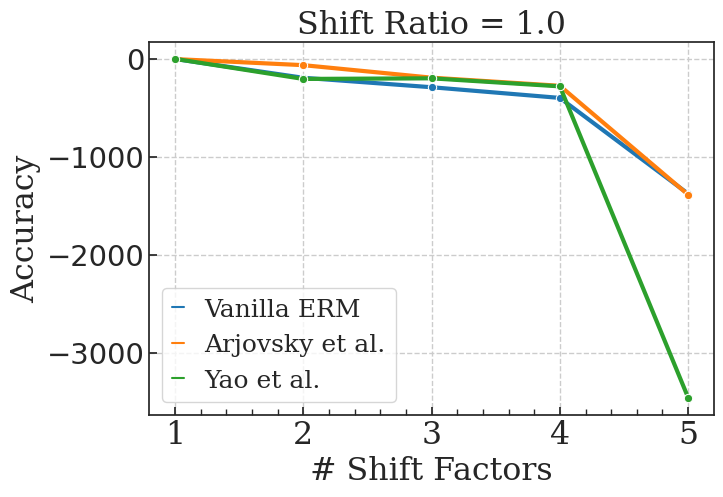

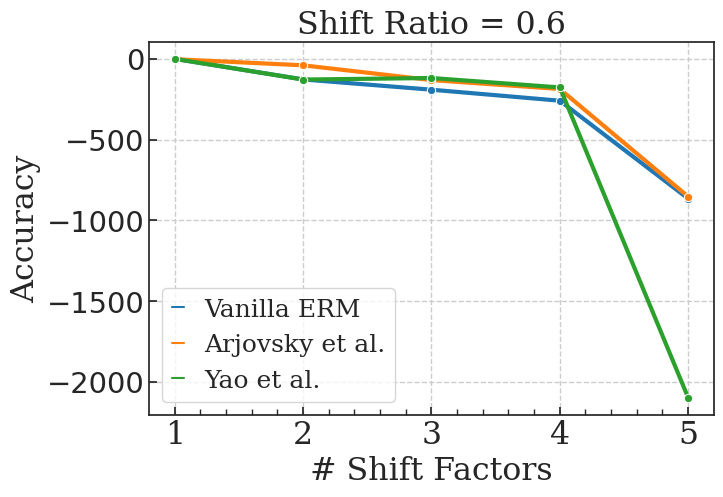

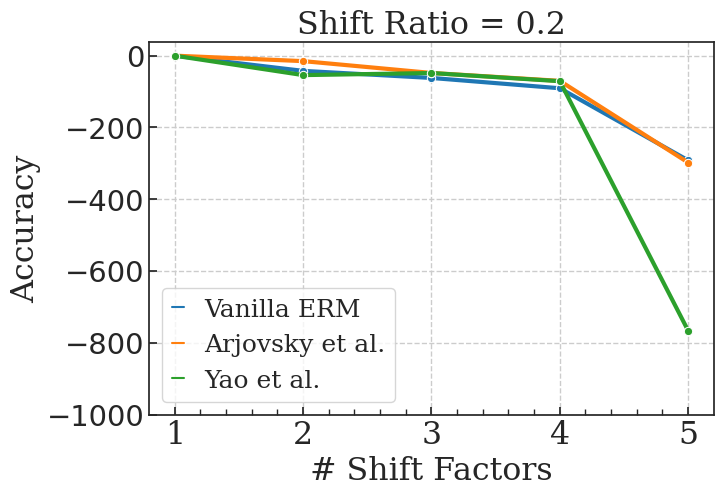

In [81]:
# Compare accuracy, specificity, precision, etc...
plot_dg_test(
        df=df,
        metric_list=["logPA"],
        selection_metric_list=["acc"],
        # xmetric="loss",
        # xlabel="loss",
        ylabel="Accuracy",
        hue_attribute="model", # either model or selection_metric
        savedir=r"/cluster/home/vjimenez/adv_pa_new/results/dg/datashift/paper/paper_sel=acc_met=acc.png",
        yscale="linear",
        legend=True,
        save=False
)

In [44]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


def plot_dg_selection_test(
        df: pd.DataFrame,
        metric: str,
        savedir: str,
        ylims: tuple = (None, None),
        legend: Optional[bool] = True,
        save: Optional[bool] = False,
    ) -> None:        

    # Get the font
    fontname = "DejaVu Serif"
    _ = fm.findfont(fm.FontProperties(family=fontname))
    
    # Create a line plot
    _, ax = plt.subplots(figsize=(2.5 * 3.861, 2 * 2.7291))
    sns.set(font_scale=1.9)
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = fontname
    sns.set_style("ticks")

    selection_metric_list = ["logPA", "acc"]
    columns_to_select = list(set(['model', 'sr', 'selection_metric', metric]))
    mask_selection_metric = df['selection_metric'].isin(selection_metric_list)
    filtered_df = df[mask_selection_metric][columns_to_select]

    # Generate a dataframe for each selection metric.
    df_list = [
        filtered_df[(filtered_df["selection_metric"] == met) & (filtered_df["sr"] == 1.0)]
        for met in selection_metric_list
    ]

    # Plot the top accuracy as a line:
    delta = 0.26
    delta_model = [-delta, 0.0, delta]
    for imodel, model in enumerate(df_list[0]["model"].unique()):
        level_set_1, level_set_2 = [
                df_list[i].loc[
                    (df_list[i]["model"] == model)
                ]
                for i in range(2)
        ]
        d = delta_model[imodel]

        print("Model: ", imodel)
        print("Accuracy: ", 100 * np.asarray(level_set_2[metric]))
        print("PA_diff: ", 100 * (np.asarray(level_set_1[metric]) - np.asarray(level_set_2[metric])))
        
        for i in range(1, 6):
            width = 0.25
            x_left, x_right = d + i - width/2.0, d + i + width/2.0
            
            ax.bar(
                x = x_left,
                align = "edge",
                width = width,
                height = level_set_2[metric].iloc[i-1], # val_acc
                color=COLORS_DICT[model],
                edgecolor=COLORS_DICT[model],
            )

            
            
            hatch = "//"
            if level_set_1[metric].iloc[i-1] > level_set_2[metric].iloc[i-1]:
                # Same, but to block the grid lines:
                ax.bar(
                    x = x_left,
                    align = "edge",
                    width = width,
                    height = level_set_1[metric].iloc[i-1] - level_set_2[metric].iloc[i-1],
                    bottom = level_set_2[metric].iloc[i-1],
                    color="white",
                )

                ax.bar(
                    x = x_left,
                    align = "edge",
                    width = width,
                    height = level_set_1[metric].iloc[i-1] - level_set_2[metric].iloc[i-1],
                    bottom = level_set_2[metric].iloc[i-1],
                    color=COLORS_DICT[model],
                    edgecolor=COLORS_DICT[model],
                    alpha=0.5,
                )
                ax.bar(
                    x = x_left,
                    align = "edge",
                    width = width,
                    height = level_set_1[metric].iloc[i-1] - level_set_2[metric].iloc[i-1],
                    bottom = level_set_2[metric].iloc[i-1],
                    facecolor='none',
                    edgecolor='lime',
                    linewidth=1.2
                )
            else:
                ax.bar(
                    x = x_left,
                    align = "edge",
                    width = width,
                    height = level_set_1[metric].iloc[i-1] - level_set_2[metric].iloc[i-1],
                    bottom = level_set_2[metric].iloc[i-1],
                    hatch="//",
                    facecolor='none',
                    edgecolor='tab:red',
                    linewidth=1.2
                )


    if legend == True:
        legend_bar = Patch(facecolor = "tab:blue")
        legend_bar_lower = Patch(facecolor = "tab:blue", hatch="//", linewidth=1.2, edgecolor='tab:red')
        legend_bar_higher = Patch(facecolor = "tab:blue", alpha=0.5, linewidth=1.2, edgecolor="lime")

        ax.legend(
            handles=[legend_bar, (legend_bar_lower, legend_bar_higher)],
            labels=["Acc. selection", "PA selection"],
            loc = "upper right",
            handlelength=1.0,
            handler_map={
                tuple: SideBySideHandler(),
            },
            prop = {
                "family": fontname,
                'size': 18
            }
        )
            

        
    ax.set_xticks([i for i in range(1,6)])

    ax.tick_params(axis="both", which="both", direction="in")
    xticks_font = fm.FontProperties(family=fontname)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(xticks_font)

    ax.grid(linestyle="--", axis="y")

    ax.set_ylim(*ylims)
    ax.set_xlim(0.5, 5.5)
        
    # posdiff = -(10**np.log10(abs(max(level_set[metric]))))/2
    # ax.set_ylim(min(level_set[metric])*2, posdiff)
    ax.set_xlabel("# Shift Factors", fontname=fontname)
    # r"$10^{-4} \times $ PA"
    
    ylabel = metric.capitalize()
    if metric == "logPA":
        ylabel = "PA"
    if metric == "acc":
        ylabel = "Accuracy"
    ax.set_ylabel(ylabel, fontname=fontname)
    ax.set_yscale("linear") 

    title = "Model selection \u2014 Early Stopping"
    ax.set_title(title, fontname=fontname)
    plt.tight_layout()
    if save:
        plt.savefig(savedir)
        plt.clf()
        plt.close()
    else:
        plt.show()

In [52]:
df = retrieve_testpaper(["lisa_00"], group="paper_nonapaired")

Run: : 0it [00:00, ?it/s]

dataframe stored in /cluster/home/vjimenez/adv_pa_new/results/dg/datashift/paper_nonapaired/test_lisa_00.pkl.


In [51]:
df.columns

Index([], dtype='object')

In [48]:
metric = "acc"
plot_dg_selection_test(
        df=df,
        metric=metric,
        ylims=(0.5, 1.2),
        legend=True,
        savedir=rf"/cluster/home/vjimenez/adv_pa_new/results/dg/datashift/paper/paper_selection_ppred=1.0_met={metric}.png",
        save=False,
)

NameError: name 'df' is not defined